In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, ExpSineSquared, RBF, RationalQuadratic
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage import median_filter
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
import time
from matplotlib.ticker import FormatStrFormatter
from scipy import stats

In [2]:
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
#sns.set_style("whitegrid")
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
df = pd.read_csv('../data/new.csv')
df = df[df['symbol'].str.contains("BTC_USD")]
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]
df

,sequence,symbol,ask_price,partitionKey,time_exchange,bid_size,id,ts,ask_size,bid_price
0,843518,QUOTE_COINBASE_SPOT_BTC_USDT,16859.76,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T16:38:06.920014Z,0.059338,e37f9170-16db-4d9b-814f-20a08f30b99d,2023-01-04T16:38:06.978777100Z,0.080000,16858.87
1,843528,QUOTE_COINBASE_SPOT_BTC_USDT,16861.29,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T16:38:07.385442Z,0.037950,84fc7f5e-fc45-4a6f-87c5-3aa5a87aad34,2023-01-04T16:38:07.444063800Z,0.010000,16859.76
2,843532,QUOTE_COINBASE_SPOT_BTC_USDT,16861.29,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T16:38:07.917096Z,0.037950,a6e068ed-66d5-42e7-9bb1-c52bc35ad239,2023-01-04T16:38:07.979444200Z,0.010000,16860.01
3,843537,QUOTE_COINBASE_SPOT_BTC_USDT,16861.29,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T16:38:08.346902Z,0.004000,1ef80b67-7d89-4729-8602-3b650760a1f6,2023-01-04T16:38:08.418239300Z,0.010000,16860.03
4,843542,QUOTE_COINBASE_SPOT_BTC_USDT,16861.29,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T16:38:08.740311Z,0.037950,b68a5ec9-61bd-447a-a545-7baccf4f0e71,2023-01-04T16:38:08.801272300Z,0.010000,16860.03
...,...,...,...,...,...,...,...,...,...,...
9831,929040,QUOTE_COINBASE_SPOT_BTC_USDT,16946.99,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T18:37:58.340078Z,0.050000,5ae8ca05-abc7-4d3d-b58b-806db17ab35e,2023-01-04T18:37:58.406542100Z,0.040000,16945.12
9832,929046,QUOTE_COINBASE_SPOT_BTC_USDT,16947.70,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T18:37:58.458843Z,0.041757,621cc719-c0d1-4465-982a-76cb777a5a37,2023-01-04T18:37:58.526687100Z,0.000046,16945.14
9833,929047,QUOTE_COINBASE_SPOT_BTC_USDT,16947.70,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T18:37:59.087730Z,0.020000,c3888cb0-8558-44be-b796-d413668be185,2023-01-04T18:37:59.157683500Z,0.000046,16945.15
9834,929050,QUOTE_COINBASE_SPOT_BTC_USDT,16947.70,QUOTE_COINBASE_SPOT_BTC_USDT,2023-01-04T18:38:00.461446Z,0.020000,751bcd7c-09bc-4d9f-addb-2386505f33d4,2023-01-04T18:38:00.529814600Z,0.000046,16945.42


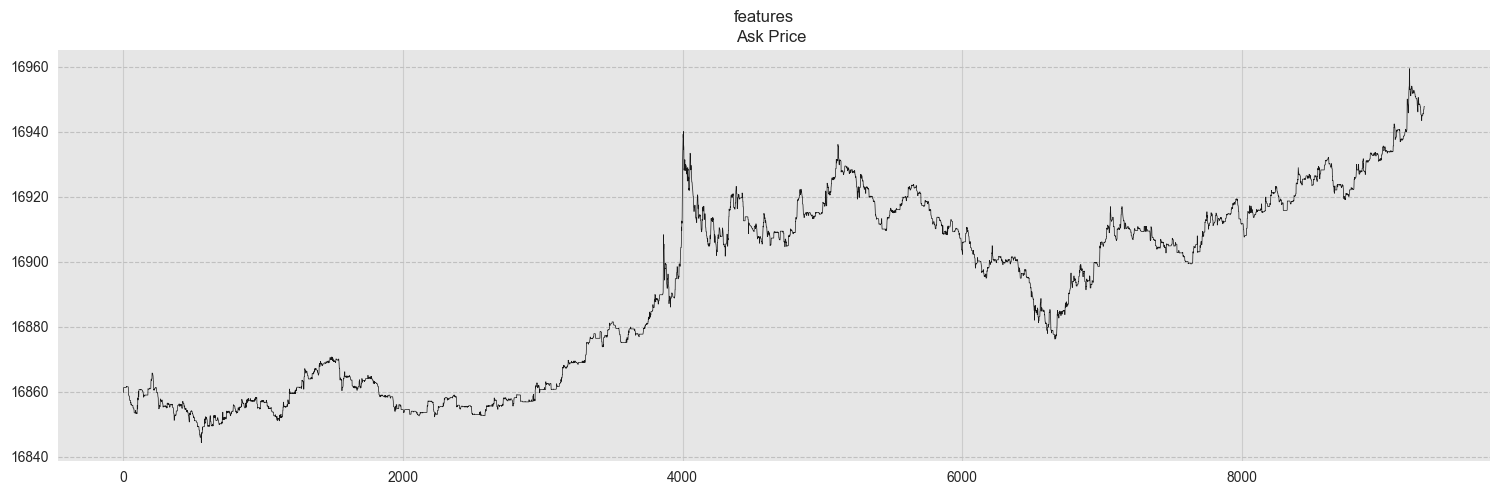

In [4]:
fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('Ask Price ')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df.shape[0]), df.ask_price, '-', color="black", alpha=0.9, linewidth=0.5)
# sp1.plot(np.arange(0, x[500:2000].shape[0]), x[500:2000].ask_price, '-', color="lime", alpha=0.9, linewidth=0.05)
# sp1.plot(np.arange(0, temp.shape[0]), temp.ask_price, '-', color="black", alpha=0.9, linewidth=0.25)
# sp1.plot(np.arange(0, x.shape[0]), x.bid_price, '-', color="orange", alpha=0.9, linewidth=0.05)


# sns.jointplot(data=x, x='ask_price', y='ask_size', kind='hex')
# plt.ylim([20800, 21600])
plt.show()

In [5]:
df['ts'] = pd.to_datetime(df['ts'])
df['ts'] = df['ts'].values.astype(np.int64) // 10 ** 9
df = df.drop(columns=['partitionKey', 'id', 'symbol', 'sequence',])

n = 5000
df = df[:n]
df = df.reset_index()
t = np.arange(len(df))
df['t'] = pd.DataFrame({'t' : t})
df

,index,ask_price,time_exchange,bid_size,ts,ask_size,bid_price,t
0,0,16859.76,2023-01-04T16:38:06.920014Z,0.059338,1672850286,0.080000,16858.87,0
1,1,16861.29,2023-01-04T16:38:07.385442Z,0.037950,1672850287,0.010000,16859.76,1
2,2,16861.29,2023-01-04T16:38:07.917096Z,0.037950,1672850287,0.010000,16860.01,2
3,3,16861.29,2023-01-04T16:38:08.346902Z,0.004000,1672850288,0.010000,16860.03,3
4,4,16861.29,2023-01-04T16:38:08.740311Z,0.037950,1672850288,0.010000,16860.03,4
...,...,...,...,...,...,...,...,...
4995,5164,16914.87,2023-01-04T17:43:24.912278Z,0.059149,1672854204,0.097092,16912.85,4995
4996,5165,16914.87,2023-01-04T17:43:28.016886Z,0.059149,1672854208,0.097092,16912.85,4996
4997,5166,16914.87,2023-01-04T17:43:29.050767Z,0.059149,1672854209,0.097200,16912.85,4997
4998,5167,16914.87,2023-01-04T17:43:30.019570Z,0.251360,1672854210,0.000108,16913.04,4998


In [6]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 1.5**2))

k1 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=1, periodicity_bounds=(1e-3, 45))

k2 = ConstantKernel(constant_value=0.1, constant_value_bounds=(1e-2, 500)) * \
  RationalQuadratic(length_scale=0.01, length_scale_bounds=(0.01, 1e8), alpha= 15.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=10, periodicity_bounds=(1, 15))

kernel_4  = k0 + k1 + k2 + k3

In [7]:
# Define GaussianProcessRegressor object.
gp4 = GaussianProcessRegressor(
    kernel=kernel_4,
    n_restarts_optimizer=10,
    normalize_y=True,
    alpha=0.0
)

In [8]:
def get_data(v, x, size):
    is_ready = False
    if len(x) < size:
        x.append(v)
    else:
        x.pop(0)
        x.append(v)
        is_ready = True
    return x, is_ready

In [9]:
def prepare_training_data(x):
    t = np.arange(size)
    dataframe = pd.DataFrame({'t' : t, 'ask_price' : np.array(x)})
    dataframe['delta'] = 10000 * (dataframe['ask_price'].shift(-1) / dataframe['ask_price'] - 1)
    dataframe.fillna(method="ffill", inplace=True)
    dataframe.fillna(method="bfill", inplace=True)
    return dataframe

In [10]:
x = []
steps_ahead = 1
#size = 20
training_data = None
#delta_preds = []
#ask_price_preds = []
#ask_price_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#delta_preds = {"20": [], "50": [], "100": [], "150": [], "200": []}
#training_preds_time = {"20": [], "50": [], "100": [], "150": [], "200": []}
ask_price_preds_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "200": []}
delta_preds_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "200": []}
training_preds_time_ahead = {"5": [], "10": [], "20": [], "50": [], "100": [], "200": []}
#[20, 50, 100, 150, 200]
for size in [5, 10, 20, 50, 100, 200]:
    for index, row in df.iterrows():
        x, is_ready = get_data(row['ask_price'], x, size)
        if is_ready:
            if (len(df) - size) <= len(ask_price_preds_ahead[str(size)]):
                break
            start = time.time()
            training_data = prepare_training_data(x)
            xx_train = training_data['t'].values.reshape(size, 1)
            yy_train = training_data['delta'].values.reshape(size, 1)
            gp4.fit(xx_train, yy_train)
            xx = np.arange(size , size + steps_ahead, 1)
            xx = xx.reshape(-1, 1)
            delta_pred, std_dev = gp4.predict(xx, return_std=True)
            end = time.time()
            delta_preds_ahead[str(size)].extend(delta_pred)
            ask_price_pred = (delta_pred / 10000 + 1) * row['ask_price']
            ask_price_preds_ahead[str(size)].extend(ask_price_pred)
            training_preds_time_ahead[str(size)].append(end - start)
            print(size,index, delta_pred, ask_price_pred, end - start)

    x = []

5 5 [0.] [16861.29] 0.38289594650268555
5 6 [0.] [16861.29] 0.4402010440826416
5 7 [0.] [16861.29] 0.3217599391937256
5 8 [0.] [16861.29] 0.27266621589660645
5 9 [0.] [16861.29] 0.27512407302856445
5 10 [0.] [16861.29] 0.27525997161865234
5 11 [0.] [16861.29] 0.29175710678100586
5 12 [0.] [16861.29] 0.23780107498168945
5 13 [0.] [16861.29] 0.2936067581176758
5 14 [0.] [16861.29] 0.4346308708190918
5 15 [0.] [16861.29] 0.29337334632873535
5 16 [0.] [16861.29] 0.3322281837463379
5 17 [0.] [16861.29] 0.3038930892944336
5 18 [0.] [16861.29] 0.3576998710632324
5 19 [0.] [16861.29] 0.32257509231567383
5 20 [0.] [16861.29] 0.2886648178100586
5 21 [0.14071034] [16861.90726114] 0.7511942386627197
5 22 [0.00335981] [16861.56566516] 0.6502430438995361
5 23 [0.03202631] [16861.61400136] 0.4161701202392578
5 24 [0.03202631] [16861.61400136] 0.5908679962158203
5 25 [-0.01304734] [16861.53800014] 0.3821229934692383
5 26 [0.] [16861.56] 0.3247087001800537
5 27 [0.] [16861.56] 0.25348520278930664
5 28 

KeyboardInterrupt: 

In [11]:
s = 5
results = pd.concat([df.iloc[s:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds_ahead[str(s)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(s)]})],  axis='columns')
results

,index,ask_price,delta_pred,ask_price_pred
0,5,16861.29,0.000000,16861.290000
1,6,16861.29,0.000000,16861.290000
2,7,16861.29,0.000000,16861.290000
3,8,16861.29,0.000000,16861.290000
4,9,16861.29,0.000000,16861.290000
...,...,...,...,...
4990,4995,16914.87,-0.012933,16914.848123
4991,4996,16914.87,-0.137091,16914.638113
4992,4997,16914.87,-0.028377,16914.822001
4993,4998,16914.87,0.000000,16914.870000


In [13]:
results_table_dict = {"window": [], "avg_training_time": [], "mean_squared_error": []}
for size in [5, 10, 20, 50, 100]:

    results_table = pd.concat([df.iloc[size:, 1:2].reset_index(), pd.DataFrame({'delta_pred' : delta_preds_ahead[str(size)]}), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(size)]})],  axis='columns')

    results_table_dict['window'].append(size)
    training_time_df = pd.DataFrame(training_preds_time_ahead[str(size)], columns =['training_time'])
    results_table_dict['avg_training_time'].append(training_time_df.mean()['training_time'])
    results_table_dict['mean_squared_error'].append(mean_squared_error(np.array(results_table['ask_price']),np.array(results_table['ask_price_pred'])))
results_table_dict

results_table_df = pd.DataFrame.from_dict(results_table_dict)
results_table_df

,window,avg_training_time,mean_squared_error
0,5,0.672492,0.356476
1,10,0.764728,0.381466
2,20,0.974058,0.293085
3,50,1.993280,0.202473
4,100,3.580082,0.106688


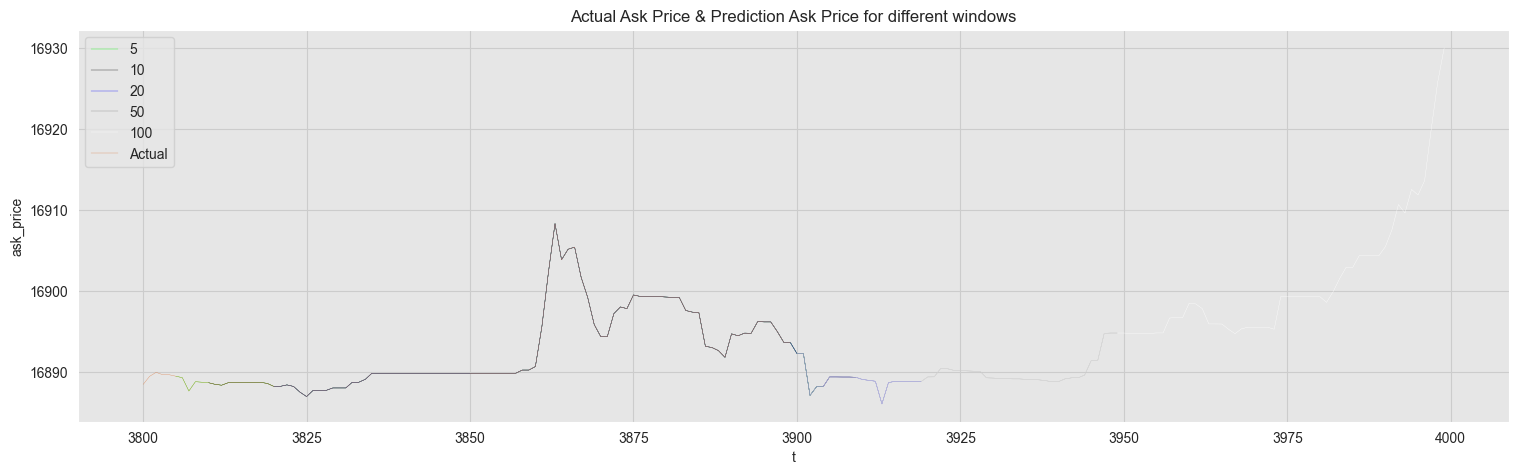

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#fig.suptitle('features')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Actual Ask Price & Prediction Ask Price for different windows', xlabel='t', ylabel='');


fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

color_dict = {"5": "lime", "10": "black", "20": "blue", "50": "grey", "100": "white"}

for size in [5, 10, 20, 50, 100]:
    temp_df = pd.concat([df.iloc[size:, 1:2].reset_index(), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(size)]})],  axis='columns')

    sns.lineplot(x='index', y='ask_price', data=temp_df.iloc[3800:3900, :], color=color_dict[str(size)], label=size, ax=ax, linewidth=0.25)


sns.lineplot(x='t', y='ask_price', data=df.iloc[3800:3900, :], color=sns_c[1], label='Actual', ax=ax, linewidth=0.25)

plt.show()

In [ ]:
temp_df = pd.concat([df.iloc[size:, 1:2].reset_index(), pd.DataFrame({'ask_price_pred' : ask_price_preds_ahead[str(size)]})],  axis='columns')
temp_df